In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


参考ページ：https://github.com/kunishou/Talking_Robot/blob/main/04_talking_robot.ipynb

# このプログラムの概念図

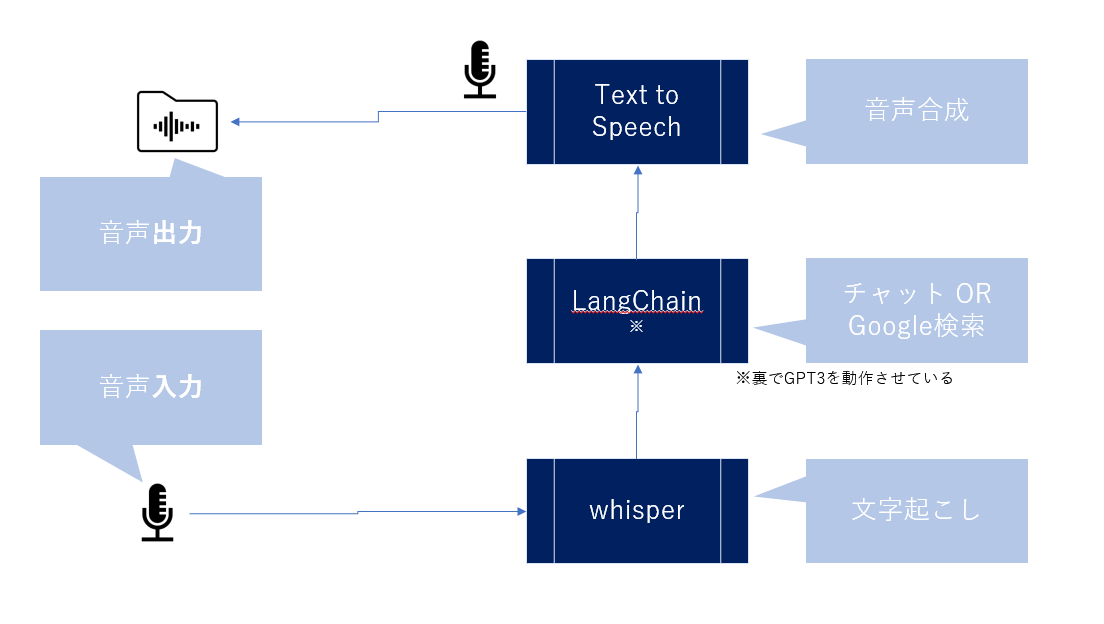

# GoogleTexttoSpeechのセットアップ
本当はVOICEVOXを使いたかったのですが、エラーで動かないので、すぐに実装できるこちらを使うことにした。

In [ ]:
# Googleの text to speechのインストール
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1


# Whisper set up

In [ ]:
! pip install git+https://github.com/openai/whisper.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-e3nkcq32
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-e3nkcq32
  Resolved https://github.com/openai/whisper.git to commit 5c1a8c10e762bf9c29fcf6b3e40f17bc8ab09864
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 116.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20230124-py3-none-any.whl size=1179333 sha256=35ee14a37ab8e571241be7e2f7b801293988d6a76af65d5c2911c843d706ff0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i70_sodh/wheels/a7/70/18/b7693c07b1d18b3dafb328f5d0496aa0d41a9c09ef332fd8e6
Successfully built open

# LangChain set up

In [ ]:
# パッケージのインストール
!pip install langchain
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 KB 17.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 KB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai: filename=openai-0.26.4-py3-none-any.whl size=67744 sha256=0ee7e66ed07f36c190874a030c1bf6f91a32d3d7cd14698bd06a1c1f0af07260
  Stored in directory: /root/.cache/pip/wheels/2b/d8/4e/268f029bd3277c1dd9e8781a0e0296e0a63822665bfa2429fc
Successfully built openai


In [ ]:
import whisper
model = whisper.load_model("large")

100%|██████████████████████████████████████| 2.87G/2.87G [00:24<00:00, 126MiB/s]


In [ ]:
# 英単語→カナ変換用ライブラリ
!pip install -q mecab-python3
!pip install -q unidic
!pip install alkana
!python -m unidic download

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.8/577.8 KB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.3/371.3 KB 21.4 MB/s eta 0:00:00
download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:13<00:00, 39.0MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.8/dist-packages/unidic/dicdir


# ローカルPCマイクのGoogleColabへの入力

Google Colab（GPUが使用可能なクラウド開発環境）で実行するため、ローカルPCマイクにしゃべりかけた内容をColab側へ入力しなくてはいけません。そのためのコードが次

In [ ]:
import glob
import librosa
import IPython
import MeCab
import unidic
import pandas as pd
import alkana
import re
import os
from IPython.display import Audio

In [ ]:
%cd /content/voicevox_core

# ローカルPCマイクでの録音設定
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)





[Errno 2] No such file or directory: '/content/voicevox_core'
/content


In [ ]:
audiofile = "audio.wav"

second = 6 #@param {type:"number"}


print(f"Speak to your microphone {second} sec...")
record(second, audiofile)
print("Done!")

Speak to your microphone 6 sec...


<IPython.core.display.Javascript object>

Done!


In [ ]:
result      = model.transcribe("audio.wav", verbose=False, language="ja")
textised_sentence = result["text"]

print(textised_sentence)

100%|██████████| 600/600 [00:08<00:00, 66.73frames/s]

マイクロソフトのレイオフについて、日本語で教えてください。


In [ ]:
# 入力した音声の確認
Audio("audio.wav")

In [ ]:
GPT_API_KEY     = "OPENAIのAPIキー"
GOOGLE_API_KEY  = "Googleカスタム検索のAPIキー" # Googleカスタム検索のAPIキー
GOOGLE_CSE_ID   = "Googleカスタム検索の検索エンジンID" # Googleカスタム検索の検索エンジンID

os.environ["OPENAI_API_KEY"]  = GPT_API_KEY
os.environ["GOOGLE_CSE_ID"]   = GOOGLE_CSE_ID 
os.environ["GOOGLE_API_KEY"]  = GOOGLE_API_KEY

In [ ]:
# パッケージのインポート

# langchain関連のパッケージインポート

# エージェント系のライブラリインポート
from langchain.agents import load_tools
from langchain.agents import initialize_agent

# OpenAI
from langchain.llms import OpenAI

# 会話用のメモリ
from langchain import ConversationChain
from langchain.chains.conversation.memory import ConversationBufferMemory # 要約しながら会話をするとき
from langchain.chains.conversation.memory import ConversationalBufferWindowMemory # ある時点までの過去の会話を記憶しながら会話をするとき


# ChatGPTっぽく使うためにはプロンプトが必要なので
from langchain.agents  import ZeroShotAgent


from langchain.agents  import AgentExecutor


from langchain.chains  import LLMChain

In [ ]:
llm = OpenAI(temperature=0.5)

# 利用するツールの定義
# ※llm-mathは必須だから加えておく

tools = load_tools(["google-search", "llm-math"],
                   llm = llm)

# 公式に記載されているChatGPTっぽく会話をさせるためのテンプレのプロンプトを一部改変
# 基本的に全文テンプレを引っ張ってきているが、
# "You have access to the following tools:"のところだけ、追加した箇所。

# プロンプトの生成&定義
prefix = """Have a conversation with a human, answering the following questions as best you can. You have access to the following tools:"""

suffix = """Begin!"
            {chat_history}
            Question: {input}
            {agent_scratchpad}
         """

prompt = ZeroShotAgent.create_prompt(tools,
                                     prefix = prefix,
                                     suffix = suffix,
                                     input_variables = ["input", "chat_history", "agent_scratchpad"])


# LLM Chainの定義
llm_chain = LLMChain(llm    = llm,
                     prompt = prompt)

# エージェントのインスタンス化
agent = ZeroShotAgent(llm_chain = llm_chain,
                      tools     = tools,
                      verbose   = True)

# メモリの定義
memory = ConversationBufferMemory(memory_key="chat_history")

# 定義したエージェントやツール、メモリを使って、エージェントのチェーンを生成
agent_chain = AgentExecutor.from_agent_and_tools(agent   = agent,
                                                 tools   = tools,
                                                 verbose = True,
                                                 memory  = memory
                                                 )

In [ ]:
answer = agent_chain.run(input = textised_sentence)



> Entering new AgentExecutor chain...
 Thought: I should look up information about Microsoft's layoffs in Japanese.
Action: Google Search
Action Input: マイクロソフトのレイオフ
Observation: Oct 19, 2022 ... 今回のレイオフで、Xbox、Xbox Cloud、Microsoft Strategic Missions and Technology organization、Azure、およびMicrosoft governmentの各部門が影響を ... Nov 22, 2022 ... アメリカの巨大IT企業の大量解雇の報道が続いています。そうした中で、マイクロソフトが興味深い｢手堅い｣戦略をとっていると筆者は指摘します。 マイクロソフトは18,000月に、組織を簡素化し、買収したノキアのデバイスおよびサービス事業を会社の全体的な戦略に合わせるための史上最大のリストラ計画を発表しました。 Jan 19, 2023 ... マイクロソフトのレイオフは、大幅なレイオフを回避したハイテク大手はグーグル（Google）とアップル（Apple）だけだという事実にも注目させる。 アップル ... 6 days ago ... ここ最近、大手IT企業が続々とレイオフをしていますが、Microsoft（マイクロソフト）も大量レイオフを行ないました。その数なんと1万人。 5 days ago ... 先週、アップル（Apple）とマイクロソフト（Microsoft）は、拡張現実（AR）と仮想現実（VR）を含む投機的なプロジェクトを一時停止したと報道された。 Jan 20, 2023 ... また、マイクロソフト（本社：ワシントン州レドモンド）は18日、22万人以上の従業員の約5%にあたる1万人の人員削減を行うと発表しました。レイオフは3 ... Jan 19, 2023 ... マイクロソフトが、今後に目を向ける取り組みの中で1万人の従業員を解雇する。 マイクロソフトCEOのサティア・ナデラは従業員へのメッセージで、この ... Jan 22, 2017 ... マイクロソフトは1月26日の四半期決算発

In [ ]:
print(answer)

マイクロソフトは2022年10月に最大のレイオフを実施し、2023年1月に1万人の従業員を解雇すると発表した。また、2022年7月には1％未満の社員に影響を及ぼすレイオフを行い、2017年1月には約700人がレイオフされると報道された。


In [ ]:
# 音声発話のためのライブラリ
from gtts import gTTS

# テキストデータから音声ファイル(wavファイル)を作成する
def GenerateWavFile(text_to_say = "こんにちは", language = "ja"):
  gtts_object = gTTS(text = text_to_say, 
                     lang = language,
                     slow = False)
  
  gtts_object.save("output.wav")

In [ ]:
GenerateWavFile(text_to_say = answer, language = "ja")

In [ ]:
# 入力した音声の確認
Audio("output.wav")

In [ ]:
print("質問：" + textised_sentence)
print("="*100)
print("回答：" + answer)

質問：マイクロソフトのレイオフについて、日本語で教えてください。
回答：マイクロソフトは2022年10月に最大のレイオフを実施し、2023年1月に1万人の従業員を解雇すると発表した。また、2022年7月には1％未満の社員に影響を及ぼすレイオフを行い、2017年1月には約700人がレイオフされると報道された。
